# 수화 이미지 분류 경진대회

## 패키지 import

In [1]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 12.1 MB/s 
     |████████████████████████████████| 948 kB 25.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=6fdbf126d6a40bb44a8821a5c59c3b07090f77cc066fd990782692e1ea3012eb
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import warnings
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings(action='ignore')

In [85]:
SEED = 22
N_FOLD = 10
SAVE_PATH = './weight5'
LEARNING_RATE = 0.002
EPOCHS = 300
BATCH_SIZE = 24

In [4]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [6]:
%cd '/content/drive/MyDrive/Dacon-Basic/수화이미지-분류/Data'

/content/drive/MyDrive/Dacon-Basic/수화이미지-분류/Data


In [7]:
# !unzip -o '/content/drive/MyDrive/Dacon-Basic/수화이미지-분류/Data/user_data.zip의 사본'

In [8]:
%cd '/content/drive/MyDrive/Dacon-Basic/수화이미지-분류'

/content/drive/MyDrive/Dacon-Basic/수화이미지-분류


In [9]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


`-` 결측치는 없다

In [11]:
df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


`-` 파일 이름과 라벨명이 한 쌍으로 되어있다

- 가중치 저장 폴더 생성

In [76]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [77]:
create_folder(SAVE_PATH)

## 데이터 셋 및 딥러닝 모델 정의

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensor
import gc

In [15]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [78]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [79]:
seed_everything(SEED) ## 재현을 위한 seed 고정

- 이미지 불러오기

In [20]:
def load_images(path):
    images = []
    for img in sorted(glob(path + '/*.png')): ## path에 들어있는 png 파일을 검색(1번부터 차례대로 검색해야 된다)
        an_img = PIL.Image.open(img)  
        img_array = np.array(an_img)  
        images.append(img_array)  
            
    images = np.array(images)
    return images

In [21]:
train_images = load_images(path='./Data/train')
test_images = load_images(path='./Data/test')

- 데이터 셋

In [22]:
class CustomDataset(Dataset):
  
    def __init__(self, images: np.array, label_list, train_mode=True, transforms=None):
        self.images = images
        self.label_list = label_list
        self.transforms = transforms
        self.train_mode = train_mode
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.train_mode:
            label = self.label_list[idx]
            return image, label
        
        return image ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images) ## 데이터 개수 반환

- 데이터 변환

In [23]:
RGB_MEAN = [np.mean((train_images[..., i] / 255)) for i in range(3)] ## 255로 나눈후 RGB 각각의 평균
RGB_STD = [np.std(train_images[..., i] / 255) for i in range(3)]  ## 255로 나눈후 RGB 각각의 표준편차

In [31]:
## 데이터 변환 방식을 정의(Agumentation)
def get_transform(train_mode=True):
    transforms = A.Compose([
        A.Resize(p=1, height=128, width=128),
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
        ToTensor() 
    ])
    
    if train_mode:
        transforms = A.Compose([
            A.Resize(p=1, height=128, width=128), 
            A.GaussNoise(p=0.5),
            A.RandomBrightnessContrast(p=0.5), 
            A.HorizontalFlip(p=0.5), 
            A.Rotate(limit=10, p=1),
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
            ToTensor() 
        ])

    return transforms ## 데이터 변환 방식을 반환

`-` 라벨을 0~10으로 변환하겠다

In [26]:
def get_label_map() -> dict:
    label_map = dict()
    label_map['10-1'] = 10
    label_map['10-2'] = 0
    
    for i in range(1, 10):
        label_map[str(i)] = i

    return label_map

In [27]:
def label_encoding_transform(label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    encoded_label = label.apply(lambda x: label_map[x])
    return encoded_label

In [28]:
def label_encoding_inverse_transform(encoded_label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    label_inverse_map = dict(zip(label_map.values(), label_map.keys()))
    label = encoded_label.apply(lambda x: label_inverse_map[x])
    return label

In [29]:
target = label_encoding_transform(df['label'])

- CNN 신경망

In [30]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.cnn_model = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4, 4), stride=1, padding='same'),
            nn.GELU(),
            nn.BatchNorm2d(32),
  
            nn.Conv2d(32, 16, kernel_size=(4, 4), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(16),

            nn.MaxPool2d(kernel_size=(4, 4), stride=2), ## max pooling

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(16),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(16),
            
            nn.AdaptiveAvgPool2d(1) ## Flatten역할 ## 이미지를 평균내서 1*1 크기로 만든다
        )

        self.linear_model = nn.Sequential(
            nn.Linear(16, 64),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 11) ## softmax는 옵티마이저(CrossEntorpyLoss)에서 수행
        )
      
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.squeeze()
        x = self.linear_model(x)
        return x

- Linear layer 가중치 초기화

In [32]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, 1/np.sqrt(y))
        m.bias.data.fill_(0)

- 조기 중단

In [33]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

## 모델 교차검증

In [82]:
skfold = StratifiedKFold(n_splits=N_FOLD, random_state=SEED, shuffle=True) ## k겹 교차검증

In [84]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.075)

In [36]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [37]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [38]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [39]:
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

for i, (train_idx, valid_idx) in enumerate(skfold.split(train_images, target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'[{i + 1} / {N_FOLD}] Fold Training......')
    
    X_train, X_valid = train_images[train_idx], train_images[valid_idx] 
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    early_stopping = EarlyStopping(patience=50,
                                   verbose=False,
                                   path=SAVE_PATH,
                                   n_fold=i+1) ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## CNN 모델
    net = CNN().to(device)
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = CustomDataset(X_train, y_train, train_mode=True, transforms=get_transform(train_mode=True))
    valid_dataset = CustomDataset(X_valid, y_valid, train_mode=True, transforms=get_transform(train_mode=False))
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

    ## optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
    ## scheduler  
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-4)

    ## fold별로 모델 학습
    for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
        net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
        valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
        net_epoch_train_loss[i].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        net_epoch_valid_loss[i].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 10 == 0 or epoch == EPOCHS - 1: 
            ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 10 != 0 and epoch != EPOCHS - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    net_avg_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(net_avg_acc):.4f}')
print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(net_avg_loss):.4f}')     

[1 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.432  valid loss = 2.4472


  4%|▎         | 11/300 [00:34<14:29,  3.01s/it]

[Epoch:  11] train loss = 2.0475  valid loss = 1.9738


  7%|▋         | 21/300 [01:04<13:49,  2.97s/it]

[Epoch:  21] train loss = 1.7616  valid loss = 1.6176


 10%|█         | 31/300 [01:33<12:57,  2.89s/it]

[Epoch:  31] train loss = 1.5808  valid loss = 1.4766


 14%|█▎        | 41/300 [02:01<12:20,  2.86s/it]

[Epoch:  41] train loss = 1.5522  valid loss = 1.504


 17%|█▋        | 51/300 [02:29<11:40,  2.81s/it]

[Epoch:  51] train loss = 1.4301  valid loss = 1.4427


 20%|██        | 61/300 [02:58<11:28,  2.88s/it]

[Epoch:  61] train loss = 1.2212  valid loss = 1.3451


 24%|██▎       | 71/300 [03:27<10:40,  2.80s/it]

[Epoch:  71] train loss = 1.0776  valid loss = 0.95221


 27%|██▋       | 81/300 [03:55<10:10,  2.79s/it]

[Epoch:  81] train loss = 0.96333  valid loss = 0.87416


 30%|███       | 91/300 [04:23<09:47,  2.81s/it]

[Epoch:  91] train loss = 0.89509  valid loss = 0.78775


 34%|███▎      | 101/300 [04:51<09:19,  2.81s/it]

[Epoch: 101] train loss = 0.9022  valid loss = 0.84027


 37%|███▋      | 111/300 [05:20<09:14,  2.93s/it]

[Epoch: 111] train loss = 1.0231  valid loss = 1.0021


 40%|████      | 121/300 [05:48<08:21,  2.80s/it]

[Epoch: 121] train loss = 0.97813  valid loss = 1.1704


 44%|████▎     | 131/300 [06:16<07:51,  2.79s/it]

[Epoch: 131] train loss = 0.90055  valid loss = 0.75209


 47%|████▋     | 141/300 [06:44<07:29,  2.82s/it]

[Epoch: 141] train loss = 0.76982  valid loss = 0.72574


 50%|█████     | 151/300 [07:13<07:18,  2.94s/it]

[Epoch: 151] train loss = 0.73518  valid loss = 0.7022


 54%|█████▎    | 161/300 [07:42<06:44,  2.91s/it]

[Epoch: 161] train loss = 0.75684  valid loss = 0.72015


 57%|█████▋    | 171/300 [08:10<06:11,  2.88s/it]

[Epoch: 171] train loss = 0.87128  valid loss = 0.86402


 60%|██████    | 181/300 [08:39<05:46,  2.91s/it]

[Epoch: 181] train loss = 0.86509  valid loss = 0.80508


 64%|██████▎   | 191/300 [09:07<05:04,  2.79s/it]

[Epoch: 191] train loss = 0.77099  valid loss = 0.67473


 67%|██████▋   | 201/300 [09:36<04:43,  2.86s/it]

[Epoch: 201] train loss = 0.69431  valid loss = 0.62989


 70%|███████   | 211/300 [10:06<04:44,  3.20s/it]

[Epoch: 211] train loss = 0.66283  valid loss = 0.59676


 74%|███████▎  | 221/300 [10:35<03:45,  2.85s/it]

[Epoch: 221] train loss = 0.68232  valid loss = 0.60899


 77%|███████▋  | 231/300 [11:03<03:14,  2.82s/it]

[Epoch: 231] train loss = 0.72724  valid loss = 0.75968


 80%|████████  | 241/300 [11:32<02:49,  2.88s/it]

[Epoch: 241] train loss = 0.83369  valid loss = 0.84915


 84%|████████▎ | 251/300 [12:01<02:24,  2.95s/it]

[Epoch: 251] train loss = 0.68301  valid loss = 0.62405


 87%|████████▋ | 261/300 [12:30<01:51,  2.85s/it]

[Epoch: 261] train loss = 0.67377  valid loss = 0.59347


 90%|█████████ | 271/300 [12:58<01:24,  2.92s/it]

[Epoch: 271] train loss = 0.636  valid loss = 0.60645


 94%|█████████▎| 281/300 [13:27<00:55,  2.93s/it]

[Epoch: 281] train loss = 0.63199  valid loss = 0.60916


 97%|█████████▋| 291/300 [13:56<00:25,  2.84s/it]

[Epoch: 291] train loss = 0.69835  valid loss = 0.62036


100%|██████████| 300/300 [14:22<00:00,  2.87s/it]


[Epoch: 300] train loss = 0.73949  valid loss = 0.82943
1 Fold -> Best Valid Loss: 0.5676  Best Valid Accuracy: 0.9535


[2 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.4265  valid loss = 2.3347


  4%|▎         | 11/300 [00:32<13:55,  2.89s/it]

[Epoch:  11] train loss = 1.8806  valid loss = 1.7297


  7%|▋         | 21/300 [01:00<13:05,  2.81s/it]

[Epoch:  21] train loss = 1.5306  valid loss = 1.4392


 10%|█         | 31/300 [01:29<12:36,  2.81s/it]

[Epoch:  31] train loss = 1.4768  valid loss = 1.3017


 14%|█▎        | 41/300 [01:56<11:55,  2.76s/it]

[Epoch:  41] train loss = 1.4222  valid loss = 1.2866


 17%|█▋        | 51/300 [02:24<11:31,  2.78s/it]

[Epoch:  51] train loss = 1.4323  valid loss = 1.4584


 20%|██        | 61/300 [02:52<11:03,  2.78s/it]

[Epoch:  61] train loss = 1.329  valid loss = 1.2339


 24%|██▎       | 71/300 [03:21<11:49,  3.10s/it]

[Epoch:  71] train loss = 1.1337  valid loss = 1.1115


 27%|██▋       | 81/300 [03:49<10:11,  2.79s/it]

[Epoch:  81] train loss = 0.94665  valid loss = 0.88009


 30%|███       | 91/300 [04:17<09:41,  2.78s/it]

[Epoch:  91] train loss = 0.91035  valid loss = 0.80872


 34%|███▎      | 101/300 [04:45<09:12,  2.78s/it]

[Epoch: 101] train loss = 0.93628  valid loss = 0.89612


 37%|███▋      | 111/300 [05:12<08:40,  2.76s/it]

[Epoch: 111] train loss = 0.97596  valid loss = 0.8456


 40%|████      | 121/300 [05:40<08:17,  2.78s/it]

[Epoch: 121] train loss = 0.97423  valid loss = 0.81234


 44%|████▎     | 131/300 [06:08<07:51,  2.79s/it]

[Epoch: 131] train loss = 0.87422  valid loss = 0.80047


 47%|████▋     | 141/300 [06:36<07:23,  2.79s/it]

[Epoch: 141] train loss = 0.75072  valid loss = 0.70282


 50%|█████     | 151/300 [07:04<06:46,  2.73s/it]

[Epoch: 151] train loss = 0.77243  valid loss = 0.68682


 54%|█████▎    | 161/300 [07:31<06:24,  2.77s/it]

[Epoch: 161] train loss = 0.76701  valid loss = 0.67869


 57%|█████▋    | 171/300 [07:59<06:06,  2.84s/it]

[Epoch: 171] train loss = 0.85442  valid loss = 0.76671


 60%|██████    | 181/300 [08:27<05:31,  2.78s/it]

[Epoch: 181] train loss = 0.86173  valid loss = 0.77879


 64%|██████▎   | 191/300 [08:55<05:02,  2.77s/it]

[Epoch: 191] train loss = 0.77538  valid loss = 0.72218


 67%|██████▋   | 201/300 [09:24<04:52,  2.96s/it]

[Epoch: 201] train loss = 0.68939  valid loss = 0.62028


 70%|███████   | 211/300 [09:53<04:11,  2.83s/it]

[Epoch: 211] train loss = 0.67582  valid loss = 0.60688


 74%|███████▎  | 221/300 [10:21<03:39,  2.78s/it]

[Epoch: 221] train loss = 0.702  valid loss = 0.60153


 77%|███████▋  | 231/300 [10:49<03:11,  2.78s/it]

[Epoch: 231] train loss = 0.71304  valid loss = 0.64355


 80%|████████  | 241/300 [11:17<02:47,  2.85s/it]

[Epoch: 241] train loss = 0.75524  valid loss = 0.78789


 84%|████████▎ | 251/300 [11:45<02:17,  2.80s/it]

[Epoch: 251] train loss = 0.72136  valid loss = 0.6587


 87%|████████▋ | 261/300 [12:12<01:48,  2.78s/it]

[Epoch: 261] train loss = 0.63969  valid loss = 0.60643


 90%|█████████ | 271/300 [12:40<01:20,  2.76s/it]

[Epoch: 271] train loss = 0.64279  valid loss = 0.57176


 94%|█████████▎| 281/300 [13:08<00:53,  2.82s/it]

[Epoch: 281] train loss = 0.64978  valid loss = 0.56656


 97%|█████████▋| 291/300 [13:36<00:25,  2.78s/it]

[Epoch: 291] train loss = 0.68874  valid loss = 0.62589


100%|██████████| 300/300 [14:01<00:00,  2.81s/it]


[Epoch: 300] train loss = 0.87738  valid loss = 0.82698
2 Fold -> Best Valid Loss: 0.5625  Best Valid Accuracy: 1.0000


[3 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.4216  valid loss = 2.3988


  4%|▎         | 11/300 [00:32<13:53,  2.88s/it]

[Epoch:  11] train loss = 1.9336  valid loss = 1.8509


  7%|▋         | 21/300 [00:59<12:46,  2.75s/it]

[Epoch:  21] train loss = 1.6579  valid loss = 1.5487


 10%|█         | 31/300 [01:27<12:29,  2.79s/it]

[Epoch:  31] train loss = 1.4846  valid loss = 1.408


 14%|█▎        | 41/300 [01:55<11:50,  2.74s/it]

[Epoch:  41] train loss = 1.4846  valid loss = 1.431


 17%|█▋        | 51/300 [02:23<11:30,  2.77s/it]

[Epoch:  51] train loss = 1.4203  valid loss = 1.3911


 20%|██        | 61/300 [02:51<11:18,  2.84s/it]

[Epoch:  61] train loss = 1.2689  valid loss = 1.2038


 24%|██▎       | 71/300 [03:19<10:43,  2.81s/it]

[Epoch:  71] train loss = 1.0857  valid loss = 1.0079


 27%|██▋       | 81/300 [03:47<10:14,  2.81s/it]

[Epoch:  81] train loss = 0.96811  valid loss = 0.90697


 30%|███       | 91/300 [04:15<09:45,  2.80s/it]

[Epoch:  91] train loss = 0.92416  valid loss = 0.88409


 34%|███▎      | 101/300 [04:43<09:18,  2.81s/it]

[Epoch: 101] train loss = 0.89405  valid loss = 0.90303


 37%|███▋      | 111/300 [05:11<08:44,  2.77s/it]

[Epoch: 111] train loss = 1.0037  valid loss = 1.1494


 40%|████      | 121/300 [05:40<08:24,  2.82s/it]

[Epoch: 121] train loss = 0.90752  valid loss = 1.0351


 44%|████▎     | 131/300 [06:08<07:51,  2.79s/it]

[Epoch: 131] train loss = 0.84748  valid loss = 0.84096


 47%|████▋     | 141/300 [06:36<07:21,  2.78s/it]

[Epoch: 141] train loss = 0.78363  valid loss = 0.81287


 50%|█████     | 151/300 [07:04<06:58,  2.81s/it]

[Epoch: 151] train loss = 0.74079  valid loss = 0.76026


 54%|█████▎    | 161/300 [07:32<06:26,  2.78s/it]

[Epoch: 161] train loss = 0.77935  valid loss = 0.80196


 57%|█████▋    | 171/300 [08:00<05:57,  2.77s/it]

[Epoch: 171] train loss = 0.76842  valid loss = 0.84742


 60%|██████    | 181/300 [08:28<05:37,  2.84s/it]

[Epoch: 181] train loss = 0.81796  valid loss = 0.83372


 64%|██████▎   | 191/300 [08:56<05:06,  2.81s/it]

[Epoch: 191] train loss = 0.75602  valid loss = 0.76879


 67%|██████▋   | 201/300 [09:24<04:47,  2.90s/it]

[Epoch: 201] train loss = 0.68971  valid loss = 0.71727


 70%|███████   | 211/300 [09:52<04:07,  2.78s/it]

[Epoch: 211] train loss = 0.69778  valid loss = 0.7252


 74%|███████▎  | 221/300 [10:22<04:07,  3.14s/it]

[Epoch: 221] train loss = 0.67973  valid loss = 0.73126


 77%|███████▋  | 231/300 [10:50<03:12,  2.79s/it]

[Epoch: 231] train loss = 0.70486  valid loss = 0.94557


 80%|████████  | 241/300 [11:17<02:42,  2.75s/it]

[Epoch: 241] train loss = 0.80965  valid loss = 0.80286


 84%|████████▎ | 251/300 [11:45<02:14,  2.75s/it]

[Epoch: 251] train loss = 0.68637  valid loss = 0.7414


 87%|████████▋ | 261/300 [12:13<01:49,  2.80s/it]

[Epoch: 261] train loss = 0.64217  valid loss = 0.69931


 90%|█████████ | 271/300 [12:41<01:21,  2.80s/it]

[Epoch: 271] train loss = 0.63931  valid loss = 0.6976


 94%|█████████▎| 281/300 [13:08<00:52,  2.76s/it]

[Epoch: 281] train loss = 0.62145  valid loss = 0.6789


 97%|█████████▋| 291/300 [13:36<00:24,  2.77s/it]

[Epoch: 291] train loss = 0.75753  valid loss = 0.80914


100%|██████████| 300/300 [14:01<00:00,  2.81s/it]


[Epoch: 300] train loss = 0.6628  valid loss = 0.75688
3 Fold -> Best Valid Loss: 0.6651  Best Valid Accuracy: 0.9070


[4 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.4235  valid loss = 2.3675


  4%|▎         | 11/300 [00:31<13:23,  2.78s/it]

[Epoch:  11] train loss = 1.9648  valid loss = 1.934


  7%|▋         | 21/300 [00:58<12:53,  2.77s/it]

[Epoch:  21] train loss = 1.6677  valid loss = 1.5081


 10%|█         | 31/300 [01:27<12:52,  2.87s/it]

[Epoch:  31] train loss = 1.4726  valid loss = 1.3677


 14%|█▎        | 41/300 [01:55<12:03,  2.79s/it]

[Epoch:  41] train loss = 1.4447  valid loss = 1.3592


 17%|█▋        | 51/300 [02:23<11:35,  2.79s/it]

[Epoch:  51] train loss = 1.3747  valid loss = 1.5028


 20%|██        | 61/300 [02:51<11:12,  2.81s/it]

[Epoch:  61] train loss = 1.2303  valid loss = 1.1342


 24%|██▎       | 71/300 [03:19<10:39,  2.79s/it]

[Epoch:  71] train loss = 1.0735  valid loss = 1.0006


 27%|██▋       | 81/300 [03:47<10:12,  2.80s/it]

[Epoch:  81] train loss = 0.93202  valid loss = 0.96547


 30%|███       | 91/300 [04:16<09:53,  2.84s/it]

[Epoch:  91] train loss = 0.89572  valid loss = 0.9416


 34%|███▎      | 101/300 [04:43<09:18,  2.80s/it]

[Epoch: 101] train loss = 0.86593  valid loss = 1.0327


 37%|███▋      | 111/300 [05:11<08:42,  2.77s/it]

[Epoch: 111] train loss = 0.97587  valid loss = 0.9887


 40%|████      | 121/300 [05:39<08:22,  2.80s/it]

[Epoch: 121] train loss = 0.95001  valid loss = 1.1359


 44%|████▎     | 131/300 [06:07<07:55,  2.81s/it]

[Epoch: 131] train loss = 0.86099  valid loss = 0.86605


 47%|████▋     | 141/300 [06:36<07:34,  2.86s/it]

[Epoch: 141] train loss = 0.76796  valid loss = 0.81809


 50%|█████     | 151/300 [07:04<07:05,  2.86s/it]

[Epoch: 151] train loss = 0.71752  valid loss = 0.80708


 54%|█████▎    | 161/300 [07:32<06:35,  2.85s/it]

[Epoch: 161] train loss = 0.76182  valid loss = 0.87003


 57%|█████▋    | 171/300 [08:01<06:11,  2.88s/it]

[Epoch: 171] train loss = 0.81504  valid loss = 0.86088


 60%|██████    | 181/300 [08:29<05:38,  2.84s/it]

[Epoch: 181] train loss = 0.83004  valid loss = 0.92286


 64%|██████▎   | 191/300 [08:58<05:06,  2.81s/it]

[Epoch: 191] train loss = 0.79879  valid loss = 0.84002


 67%|██████▋   | 201/300 [09:26<04:41,  2.85s/it]

[Epoch: 201] train loss = 0.69638  valid loss = 0.75515


 70%|███████   | 211/300 [09:54<04:09,  2.81s/it]

[Epoch: 211] train loss = 0.68582  valid loss = 0.78253


 74%|███████▎  | 221/300 [10:22<03:40,  2.79s/it]

[Epoch: 221] train loss = 0.66177  valid loss = 0.74969


 77%|███████▋  | 231/300 [10:50<03:14,  2.82s/it]

[Epoch: 231] train loss = 0.75555  valid loss = 0.7888


 80%|████████  | 241/300 [11:19<02:45,  2.81s/it]

[Epoch: 241] train loss = 0.77434  valid loss = 0.81574


 84%|████████▎ | 251/300 [11:49<02:25,  2.96s/it]

[Epoch: 251] train loss = 0.67519  valid loss = 0.77857


 87%|████████▋ | 261/300 [12:17<01:49,  2.80s/it]

[Epoch: 261] train loss = 0.66146  valid loss = 0.70326


 90%|█████████ | 271/300 [12:45<01:22,  2.85s/it]

[Epoch: 271] train loss = 0.63453  valid loss = 0.76983


 94%|█████████▎| 281/300 [13:13<00:52,  2.75s/it]

[Epoch: 281] train loss = 0.62121  valid loss = 0.79012


 97%|█████████▋| 291/300 [13:41<00:24,  2.76s/it]

[Epoch: 291] train loss = 0.65876  valid loss = 0.83904


100%|██████████| 300/300 [14:05<00:00,  2.82s/it]


[Epoch: 300] train loss = 0.72985  valid loss = 0.91001
4 Fold -> Best Valid Loss: 0.7028  Best Valid Accuracy: 0.8837


[5 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.408  valid loss = 2.3462


  4%|▎         | 11/300 [00:31<13:27,  2.79s/it]

[Epoch:  11] train loss = 1.9313  valid loss = 1.9568


  7%|▋         | 21/300 [00:59<12:56,  2.78s/it]

[Epoch:  21] train loss = 1.6421  valid loss = 1.6288


 10%|█         | 31/300 [01:27<12:29,  2.79s/it]

[Epoch:  31] train loss = 1.5081  valid loss = 1.5893


 14%|█▎        | 41/300 [01:56<12:41,  2.94s/it]

[Epoch:  41] train loss = 1.471  valid loss = 1.5094


 17%|█▋        | 51/300 [02:25<12:36,  3.04s/it]

[Epoch:  51] train loss = 1.4539  valid loss = 1.4714


 20%|██        | 61/300 [02:52<11:11,  2.81s/it]

[Epoch:  61] train loss = 1.3304  valid loss = 1.3553


 24%|██▎       | 71/300 [03:20<10:28,  2.74s/it]

[Epoch:  71] train loss = 1.117  valid loss = 1.2642


 27%|██▋       | 81/300 [03:47<10:01,  2.74s/it]

[Epoch:  81] train loss = 0.99688  valid loss = 1.0135


 30%|███       | 91/300 [04:15<09:43,  2.79s/it]

[Epoch:  91] train loss = 0.93067  valid loss = 0.95829


 34%|███▎      | 101/300 [04:43<09:12,  2.78s/it]

[Epoch: 101] train loss = 0.93072  valid loss = 0.97077


 37%|███▋      | 111/300 [05:11<08:50,  2.80s/it]

[Epoch: 111] train loss = 1.0385  valid loss = 1.0994


 40%|████      | 121/300 [05:39<08:13,  2.75s/it]

[Epoch: 121] train loss = 0.93474  valid loss = 1.0882


 44%|████▎     | 131/300 [06:06<07:42,  2.74s/it]

[Epoch: 131] train loss = 0.84566  valid loss = 0.94368


 47%|████▋     | 141/300 [06:33<07:11,  2.71s/it]

[Epoch: 141] train loss = 0.77953  valid loss = 0.84645


 50%|█████     | 151/300 [07:01<06:43,  2.71s/it]

[Epoch: 151] train loss = 0.74348  valid loss = 0.84617


 54%|█████▎    | 161/300 [07:28<06:22,  2.75s/it]

[Epoch: 161] train loss = 0.75629  valid loss = 0.80976


 57%|█████▋    | 171/300 [07:56<05:51,  2.72s/it]

[Epoch: 171] train loss = 0.87668  valid loss = 0.94785


 60%|██████    | 181/300 [08:23<05:24,  2.73s/it]

[Epoch: 181] train loss = 0.79703  valid loss = 0.91111


 64%|██████▎   | 191/300 [08:50<04:57,  2.73s/it]

[Epoch: 191] train loss = 0.75228  valid loss = 0.84344


 67%|██████▋   | 201/300 [09:18<04:31,  2.75s/it]

[Epoch: 201] train loss = 0.66417  valid loss = 0.79155


 70%|███████   | 211/300 [09:45<04:05,  2.76s/it]

[Epoch: 211] train loss = 0.65995  valid loss = 0.77957


 74%|███████▎  | 221/300 [10:13<03:36,  2.74s/it]

[Epoch: 221] train loss = 0.68509  valid loss = 0.80601


 77%|███████▋  | 231/300 [10:42<03:11,  2.78s/it]

[Epoch: 231] train loss = 0.75175  valid loss = 0.8986


 80%|████████  | 241/300 [11:10<02:44,  2.79s/it]

[Epoch: 241] train loss = 0.75963  valid loss = 0.79707


 84%|████████▎ | 251/300 [11:38<02:17,  2.80s/it]

[Epoch: 251] train loss = 0.73188  valid loss = 0.85548


 87%|████████▋ | 261/300 [12:05<01:47,  2.74s/it]

[Epoch: 261] train loss = 0.62436  valid loss = 0.82595


 90%|█████████ | 271/300 [12:33<01:19,  2.75s/it]

[Epoch: 271] train loss = 0.61136  valid loss = 0.79353


 94%|█████████▎| 281/300 [13:01<00:52,  2.75s/it]

[Epoch: 281] train loss = 0.62168  valid loss = 0.7676


 97%|█████████▋| 291/300 [13:28<00:25,  2.79s/it]

[Epoch: 291] train loss = 0.66902  valid loss = 0.85487


100%|██████████| 300/300 [13:54<00:00,  2.78s/it]


[Epoch: 300] train loss = 0.66862  valid loss = 0.96541
5 Fold -> Best Valid Loss: 0.7396  Best Valid Accuracy: 0.9070


[6 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.4248  valid loss = 2.355


  4%|▎         | 11/300 [00:31<13:19,  2.77s/it]

[Epoch:  11] train loss = 1.9005  valid loss = 1.7283


  7%|▋         | 21/300 [00:59<13:09,  2.83s/it]

[Epoch:  21] train loss = 1.5889  valid loss = 1.4341


 10%|█         | 31/300 [01:26<12:23,  2.76s/it]

[Epoch:  31] train loss = 1.4507  valid loss = 1.3669


 14%|█▎        | 41/300 [01:54<12:03,  2.79s/it]

[Epoch:  41] train loss = 1.435  valid loss = 1.3708


 17%|█▋        | 51/300 [02:22<11:36,  2.80s/it]

[Epoch:  51] train loss = 1.3362  valid loss = 1.2253


 20%|██        | 61/300 [02:51<11:16,  2.83s/it]

[Epoch:  61] train loss = 1.2278  valid loss = 1.1855


 24%|██▎       | 71/300 [03:18<10:38,  2.79s/it]

[Epoch:  71] train loss = 1.099  valid loss = 1.2178


 27%|██▋       | 81/300 [03:46<10:10,  2.79s/it]

[Epoch:  81] train loss = 0.95731  valid loss = 0.95766


 30%|███       | 91/300 [04:14<09:40,  2.78s/it]

[Epoch:  91] train loss = 0.92533  valid loss = 0.92813


 34%|███▎      | 101/300 [04:42<09:17,  2.80s/it]

[Epoch: 101] train loss = 0.94312  valid loss = 0.94916


 37%|███▋      | 111/300 [05:09<08:43,  2.77s/it]

[Epoch: 111] train loss = 0.95913  valid loss = 1.0359


 40%|████      | 121/300 [05:37<08:20,  2.80s/it]

[Epoch: 121] train loss = 1.0145  valid loss = 1.0998


 44%|████▎     | 131/300 [06:05<07:44,  2.75s/it]

[Epoch: 131] train loss = 0.84731  valid loss = 0.9486


 47%|████▋     | 141/300 [06:33<07:28,  2.82s/it]

[Epoch: 141] train loss = 0.77148  valid loss = 0.94109


 50%|█████     | 151/300 [07:01<07:08,  2.88s/it]

[Epoch: 151] train loss = 0.73603  valid loss = 0.90408


 54%|█████▎    | 161/300 [07:28<06:15,  2.70s/it]

[Epoch: 161] train loss = 0.75872  valid loss = 0.96834


 57%|█████▋    | 171/300 [07:57<06:31,  3.03s/it]

[Epoch: 171] train loss = 0.88771  valid loss = 1.0583


 60%|██████    | 181/300 [08:25<05:26,  2.74s/it]

[Epoch: 181] train loss = 0.81838  valid loss = 0.87924


 64%|██████▎   | 191/300 [08:52<04:56,  2.72s/it]

[Epoch: 191] train loss = 0.81676  valid loss = 0.93333


 67%|██████▋   | 201/300 [09:20<04:35,  2.78s/it]

[Epoch: 201] train loss = 0.70399  valid loss = 0.80723


 70%|███████   | 211/300 [09:47<04:05,  2.76s/it]

[Epoch: 211] train loss = 0.66988  valid loss = 0.84031


 74%|███████▎  | 221/300 [10:15<03:37,  2.75s/it]

[Epoch: 221] train loss = 0.69681  valid loss = 0.86729


 77%|███████▋  | 231/300 [10:43<03:15,  2.83s/it]

[Epoch: 231] train loss = 0.79298  valid loss = 0.97906


 80%|████████  | 241/300 [11:11<02:44,  2.79s/it]

[Epoch: 241] train loss = 0.79491  valid loss = 0.84737


 84%|████████▎ | 251/300 [11:38<02:14,  2.75s/it]

[Epoch: 251] train loss = 0.67892  valid loss = 0.76808


 87%|████████▋ | 261/300 [12:06<01:48,  2.79s/it]

[Epoch: 261] train loss = 0.63003  valid loss = 0.7176


 90%|█████████ | 271/300 [12:34<01:20,  2.79s/it]

[Epoch: 271] train loss = 0.60703  valid loss = 0.70042


 94%|█████████▎| 281/300 [13:02<00:52,  2.76s/it]

[Epoch: 281] train loss = 0.64753  valid loss = 0.77628


 97%|█████████▋| 291/300 [13:30<00:25,  2.80s/it]

[Epoch: 291] train loss = 0.83387  valid loss = 0.85455


100%|██████████| 300/300 [13:56<00:00,  2.79s/it]


[Epoch: 300] train loss = 0.71421  valid loss = 0.82052
6 Fold -> Best Valid Loss: 0.6937  Best Valid Accuracy: 0.9186


[7 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.4399  valid loss = 2.388


  4%|▎         | 11/300 [00:31<13:30,  2.80s/it]

[Epoch:  11] train loss = 1.9218  valid loss = 1.8402


  7%|▋         | 21/300 [00:59<13:12,  2.84s/it]

[Epoch:  21] train loss = 1.6729  valid loss = 1.561


 10%|█         | 31/300 [01:27<12:25,  2.77s/it]

[Epoch:  31] train loss = 1.5183  valid loss = 1.4733


 14%|█▎        | 41/300 [01:54<11:52,  2.75s/it]

[Epoch:  41] train loss = 1.5045  valid loss = 1.4255


 17%|█▋        | 51/300 [02:22<11:39,  2.81s/it]

[Epoch:  51] train loss = 1.4281  valid loss = 1.4681


 20%|██        | 61/300 [02:50<10:58,  2.76s/it]

[Epoch:  61] train loss = 1.3145  valid loss = 1.3063


 24%|██▎       | 71/300 [03:18<10:41,  2.80s/it]

[Epoch:  71] train loss = 1.1582  valid loss = 1.2253


 27%|██▋       | 81/300 [03:46<10:06,  2.77s/it]

[Epoch:  81] train loss = 0.99515  valid loss = 1.0284


 30%|███       | 91/300 [04:14<09:41,  2.78s/it]

[Epoch:  91] train loss = 0.91094  valid loss = 0.94676


 34%|███▎      | 101/300 [04:41<09:07,  2.75s/it]

[Epoch: 101] train loss = 0.90452  valid loss = 0.92972


 37%|███▋      | 111/300 [05:10<08:44,  2.77s/it]

[Epoch: 111] train loss = 0.96026  valid loss = 1.0138


 40%|████      | 121/300 [05:38<08:09,  2.73s/it]

[Epoch: 121] train loss = 0.99434  valid loss = 1.0431


 44%|████▎     | 131/300 [06:05<07:45,  2.75s/it]

[Epoch: 131] train loss = 0.83272  valid loss = 0.95575


 47%|████▋     | 141/300 [06:33<07:20,  2.77s/it]

[Epoch: 141] train loss = 0.78892  valid loss = 0.88555


 50%|█████     | 151/300 [07:00<06:45,  2.72s/it]

[Epoch: 151] train loss = 0.71131  valid loss = 0.84475


 54%|█████▎    | 161/300 [07:28<06:22,  2.75s/it]

[Epoch: 161] train loss = 0.7473  valid loss = 0.87053


 57%|█████▋    | 171/300 [07:55<05:59,  2.78s/it]

[Epoch: 171] train loss = 0.81074  valid loss = 0.9094


 60%|██████    | 181/300 [08:23<05:23,  2.72s/it]

[Epoch: 181] train loss = 0.79684  valid loss = 0.96356


 64%|██████▎   | 191/300 [08:50<05:00,  2.75s/it]

[Epoch: 191] train loss = 0.78358  valid loss = 0.84684


 67%|██████▋   | 201/300 [09:18<04:31,  2.74s/it]

[Epoch: 201] train loss = 0.66653  valid loss = 0.8343


 70%|███████   | 211/300 [09:45<04:03,  2.73s/it]

[Epoch: 211] train loss = 0.65292  valid loss = 0.81926


 74%|███████▎  | 221/300 [10:13<03:37,  2.76s/it]

[Epoch: 221] train loss = 0.68902  valid loss = 0.84506


 77%|███████▋  | 231/300 [10:42<03:13,  2.80s/it]

[Epoch: 231] train loss = 0.78248  valid loss = 0.92523


 80%|████████  | 241/300 [11:09<02:41,  2.74s/it]

[Epoch: 241] train loss = 0.72673  valid loss = 0.82911


 84%|████████▎ | 251/300 [11:36<02:14,  2.75s/it]

[Epoch: 251] train loss = 0.66721  valid loss = 0.88432


 85%|████████▌ | 256/300 [11:53<02:02,  2.79s/it]


[Epoch: 257] train loss = 0.64619  valid loss = 0.87049
Early stopping!
7 Fold -> Best Valid Loss: 0.7842  Best Valid Accuracy: 0.8488


[8 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.4109  valid loss = 2.3748


  4%|▎         | 11/300 [00:30<13:11,  2.74s/it]

[Epoch:  11] train loss = 1.8879  valid loss = 1.8915


  7%|▋         | 21/300 [00:58<12:59,  2.79s/it]

[Epoch:  21] train loss = 1.5701  valid loss = 1.5049


 10%|█         | 31/300 [01:26<12:19,  2.75s/it]

[Epoch:  31] train loss = 1.4509  valid loss = 1.3892


 14%|█▎        | 41/300 [01:53<11:41,  2.71s/it]

[Epoch:  41] train loss = 1.4437  valid loss = 1.4871


 17%|█▋        | 51/300 [02:21<11:48,  2.84s/it]

[Epoch:  51] train loss = 1.3998  valid loss = 1.5708


 20%|██        | 61/300 [02:49<11:10,  2.80s/it]

[Epoch:  61] train loss = 1.2027  valid loss = 1.1891


 24%|██▎       | 71/300 [03:16<10:31,  2.76s/it]

[Epoch:  71] train loss = 1.073  valid loss = 0.98424


 27%|██▋       | 81/300 [03:44<09:59,  2.74s/it]

[Epoch:  81] train loss = 0.9476  valid loss = 0.89159


 30%|███       | 91/300 [04:13<10:02,  2.88s/it]

[Epoch:  91] train loss = 0.90879  valid loss = 0.83216


 34%|███▎      | 101/300 [04:41<09:10,  2.77s/it]

[Epoch: 101] train loss = 0.88536  valid loss = 0.84159


 37%|███▋      | 111/300 [05:09<08:49,  2.80s/it]

[Epoch: 111] train loss = 0.99906  valid loss = 0.97286


 40%|████      | 121/300 [05:36<08:08,  2.73s/it]

[Epoch: 121] train loss = 0.94692  valid loss = 0.91969


 44%|████▎     | 131/300 [06:03<07:44,  2.75s/it]

[Epoch: 131] train loss = 0.83327  valid loss = 0.88807


 47%|████▋     | 141/300 [06:31<07:25,  2.80s/it]

[Epoch: 141] train loss = 0.75268  valid loss = 0.78276


 50%|█████     | 151/300 [06:59<06:59,  2.82s/it]

[Epoch: 151] train loss = 0.74425  valid loss = 0.72882


 54%|█████▎    | 161/300 [07:27<06:33,  2.83s/it]

[Epoch: 161] train loss = 0.74593  valid loss = 0.71


 57%|█████▋    | 171/300 [07:55<06:01,  2.80s/it]

[Epoch: 171] train loss = 0.78492  valid loss = 0.78895


 60%|██████    | 181/300 [08:22<05:26,  2.74s/it]

[Epoch: 181] train loss = 0.81303  valid loss = 0.88074


 64%|██████▎   | 191/300 [08:50<04:59,  2.75s/it]

[Epoch: 191] train loss = 0.80166  valid loss = 0.77476


 67%|██████▋   | 201/300 [09:17<04:29,  2.72s/it]

[Epoch: 201] train loss = 0.71462  valid loss = 0.74708


 70%|███████   | 211/300 [09:46<04:19,  2.91s/it]

[Epoch: 211] train loss = 0.65146  valid loss = 0.68176


 74%|███████▎  | 221/300 [10:14<03:36,  2.74s/it]

[Epoch: 221] train loss = 0.64958  valid loss = 0.6602


 77%|███████▋  | 231/300 [10:41<03:10,  2.77s/it]

[Epoch: 231] train loss = 0.75805  valid loss = 0.73356


 80%|████████  | 241/300 [11:09<02:43,  2.77s/it]

[Epoch: 241] train loss = 0.77164  valid loss = 0.86549


 84%|████████▎ | 251/300 [11:37<02:16,  2.80s/it]

[Epoch: 251] train loss = 0.68335  valid loss = 0.67903


 87%|████████▋ | 261/300 [12:04<01:48,  2.78s/it]

[Epoch: 261] train loss = 0.69891  valid loss = 0.68548


 90%|█████████ | 271/300 [12:32<01:19,  2.73s/it]

[Epoch: 271] train loss = 0.63024  valid loss = 0.66565


 94%|█████████▎| 281/300 [12:59<00:52,  2.77s/it]

[Epoch: 281] train loss = 0.63275  valid loss = 0.63066


 97%|█████████▋| 291/300 [13:27<00:24,  2.78s/it]

[Epoch: 291] train loss = 0.67386  valid loss = 0.67675


100%|██████████| 300/300 [13:52<00:00,  2.77s/it]


[Epoch: 300] train loss = 0.70743  valid loss = 0.66151
8 Fold -> Best Valid Loss: 0.6234  Best Valid Accuracy: 0.9302


[9 / 10] Fold Training......


  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.422  valid loss = 2.3944


  4%|▎         | 11/300 [00:31<13:23,  2.78s/it]

[Epoch:  11] train loss = 1.8573  valid loss = 1.8628


  7%|▋         | 21/300 [00:58<12:58,  2.79s/it]

[Epoch:  21] train loss = 1.5597  valid loss = 1.4532


 10%|█         | 31/300 [01:27<13:38,  3.04s/it]

[Epoch:  31] train loss = 1.4359  valid loss = 1.3187


 14%|█▎        | 41/300 [01:55<11:57,  2.77s/it]

[Epoch:  41] train loss = 1.4287  valid loss = 1.3045


 17%|█▋        | 51/300 [02:22<11:23,  2.75s/it]

[Epoch:  51] train loss = 1.3754  valid loss = 1.2795


 20%|██        | 61/300 [02:50<11:21,  2.85s/it]

[Epoch:  61] train loss = 1.2621  valid loss = 1.2898


 24%|██▎       | 71/300 [03:19<10:45,  2.82s/it]

[Epoch:  71] train loss = 1.0738  valid loss = 1.0331


 27%|██▋       | 81/300 [03:47<10:10,  2.79s/it]

[Epoch:  81] train loss = 0.88607  valid loss = 0.97426


 30%|███       | 91/300 [04:15<09:42,  2.79s/it]

[Epoch:  91] train loss = 0.86259  valid loss = 0.90129


 34%|███▎      | 101/300 [04:42<09:09,  2.76s/it]

[Epoch: 101] train loss = 0.88331  valid loss = 0.91704


 37%|███▋      | 111/300 [05:10<08:51,  2.81s/it]

[Epoch: 111] train loss = 0.95877  valid loss = 1.0286


 40%|████      | 121/300 [05:38<08:10,  2.74s/it]

[Epoch: 121] train loss = 1.0229  valid loss = 1.1376


 44%|████▎     | 131/300 [06:06<07:51,  2.79s/it]

[Epoch: 131] train loss = 0.84115  valid loss = 0.92089


 47%|████▋     | 141/300 [06:34<07:29,  2.83s/it]

[Epoch: 141] train loss = 0.72575  valid loss = 0.77055


 50%|█████     | 151/300 [07:02<06:55,  2.79s/it]

[Epoch: 151] train loss = 0.71225  valid loss = 0.73661


 54%|█████▎    | 161/300 [07:32<06:38,  2.87s/it]

[Epoch: 161] train loss = 0.71837  valid loss = 0.72541


 57%|█████▋    | 171/300 [08:00<05:57,  2.77s/it]

[Epoch: 171] train loss = 0.78691  valid loss = 0.7744


 60%|██████    | 181/300 [08:28<05:35,  2.82s/it]

[Epoch: 181] train loss = 0.79509  valid loss = 0.90181


 64%|██████▎   | 191/300 [08:56<05:08,  2.83s/it]

[Epoch: 191] train loss = 0.74312  valid loss = 0.73462


 67%|██████▋   | 201/300 [09:24<04:30,  2.73s/it]

[Epoch: 201] train loss = 0.66298  valid loss = 0.7075


 70%|███████   | 211/300 [09:51<04:06,  2.77s/it]

[Epoch: 211] train loss = 0.63405  valid loss = 0.72485


 74%|███████▎  | 221/300 [10:19<03:38,  2.77s/it]

[Epoch: 221] train loss = 0.61664  valid loss = 0.68974


 77%|███████▋  | 231/300 [10:47<03:08,  2.74s/it]

[Epoch: 231] train loss = 0.68727  valid loss = 0.87109


 80%|████████  | 241/300 [11:14<02:42,  2.75s/it]

[Epoch: 241] train loss = 0.71108  valid loss = 0.76861


 84%|████████▎ | 251/300 [11:42<02:16,  2.78s/it]

[Epoch: 251] train loss = 0.6672  valid loss = 0.71811


 87%|████████▋ | 261/300 [12:09<01:48,  2.78s/it]

[Epoch: 261] train loss = 0.59027  valid loss = 0.67554


 90%|█████████ | 271/300 [12:38<01:23,  2.86s/it]

[Epoch: 271] train loss = 0.59507  valid loss = 0.66827


 94%|█████████▎| 281/300 [13:07<00:56,  2.99s/it]

[Epoch: 281] train loss = 0.60572  valid loss = 0.64291


 97%|█████████▋| 291/300 [13:36<00:26,  2.89s/it]

[Epoch: 291] train loss = 0.61154  valid loss = 0.73709


100%|██████████| 300/300 [14:02<00:00,  2.81s/it]


[Epoch: 300] train loss = 0.74017  valid loss = 0.87644
9 Fold -> Best Valid Loss: 0.6330  Best Valid Accuracy: 0.9294


[10 / 10] Fold Training......


  0%|          | 1/300 [00:02<14:14,  2.86s/it]

[Epoch:   1] train loss = 2.429  valid loss = 2.3953


  4%|▎         | 11/300 [00:31<13:39,  2.84s/it]

[Epoch:  11] train loss = 1.9018  valid loss = 1.8373


  7%|▋         | 21/300 [00:59<13:22,  2.88s/it]

[Epoch:  21] train loss = 1.6143  valid loss = 1.4885


 10%|█         | 31/300 [01:28<12:32,  2.80s/it]

[Epoch:  31] train loss = 1.4636  valid loss = 1.3461


 14%|█▎        | 41/300 [01:56<12:11,  2.83s/it]

[Epoch:  41] train loss = 1.4257  valid loss = 1.3339


 17%|█▋        | 51/300 [02:25<11:42,  2.82s/it]

[Epoch:  51] train loss = 1.4152  valid loss = 1.765


 20%|██        | 61/300 [02:53<11:19,  2.85s/it]

[Epoch:  61] train loss = 1.2773  valid loss = 1.1272


 24%|██▎       | 71/300 [03:22<10:53,  2.85s/it]

[Epoch:  71] train loss = 1.1275  valid loss = 0.927


 27%|██▋       | 81/300 [03:50<10:32,  2.89s/it]

[Epoch:  81] train loss = 0.90252  valid loss = 0.76775


 30%|███       | 91/300 [04:18<09:43,  2.79s/it]

[Epoch:  91] train loss = 0.85362  valid loss = 0.74489


 34%|███▎      | 101/300 [04:47<09:27,  2.85s/it]

[Epoch: 101] train loss = 0.88996  valid loss = 0.74118


 37%|███▋      | 111/300 [05:16<08:52,  2.81s/it]

[Epoch: 111] train loss = 0.96915  valid loss = 0.78086


 40%|████      | 121/300 [05:44<08:26,  2.83s/it]

[Epoch: 121] train loss = 0.88274  valid loss = 0.77393


 44%|████▎     | 131/300 [06:12<07:52,  2.79s/it]

[Epoch: 131] train loss = 0.81446  valid loss = 0.78433


 47%|████▋     | 141/300 [06:40<07:24,  2.80s/it]

[Epoch: 141] train loss = 0.73488  valid loss = 0.63356


 50%|█████     | 151/300 [07:08<06:55,  2.79s/it]

[Epoch: 151] train loss = 0.70845  valid loss = 0.62046


 54%|█████▎    | 161/300 [07:36<06:20,  2.74s/it]

[Epoch: 161] train loss = 0.71402  valid loss = 0.62471


 57%|█████▋    | 171/300 [08:04<05:57,  2.77s/it]

[Epoch: 171] train loss = 0.82647  valid loss = 0.75712


 60%|██████    | 181/300 [08:32<05:31,  2.79s/it]

[Epoch: 181] train loss = 0.75594  valid loss = 0.67135


 64%|██████▎   | 191/300 [09:00<05:11,  2.86s/it]

[Epoch: 191] train loss = 0.75887  valid loss = 0.66934


 67%|██████▋   | 201/300 [09:27<04:34,  2.78s/it]

[Epoch: 201] train loss = 0.66163  valid loss = 0.59003


 70%|███████   | 211/300 [09:55<04:08,  2.79s/it]

[Epoch: 211] train loss = 0.65979  valid loss = 0.57261


 74%|███████▎  | 221/300 [10:23<03:36,  2.74s/it]

[Epoch: 221] train loss = 0.67692  valid loss = 0.58266


 77%|███████▋  | 231/300 [10:51<03:15,  2.83s/it]

[Epoch: 231] train loss = 0.68452  valid loss = 0.67755


 80%|████████  | 241/300 [11:19<02:44,  2.79s/it]

[Epoch: 241] train loss = 0.77132  valid loss = 0.69029


 84%|████████▎ | 251/300 [11:47<02:17,  2.80s/it]

[Epoch: 251] train loss = 0.69036  valid loss = 0.65421


 87%|████████▋ | 261/300 [12:15<01:50,  2.82s/it]

[Epoch: 261] train loss = 0.6057  valid loss = 0.56332


 90%|█████████ | 271/300 [12:43<01:21,  2.83s/it]

[Epoch: 271] train loss = 0.6023  valid loss = 0.5587


 94%|█████████▎| 281/300 [13:11<00:52,  2.76s/it]

[Epoch: 281] train loss = 0.61228  valid loss = 0.55954


 97%|█████████▋| 291/300 [13:39<00:25,  2.80s/it]

[Epoch: 291] train loss = 0.67848  valid loss = 0.651


100%|██████████| 300/300 [14:04<00:00,  2.81s/it]

[Epoch: 300] train loss = 0.7832  valid loss = 0.72047
10 Fold -> Best Valid Loss: 0.5517  Best Valid Accuracy: 0.9765


10 Fold Mean Valid Accuracy: 0.9255
10 Fold Mean Valid Loss: 0.6524


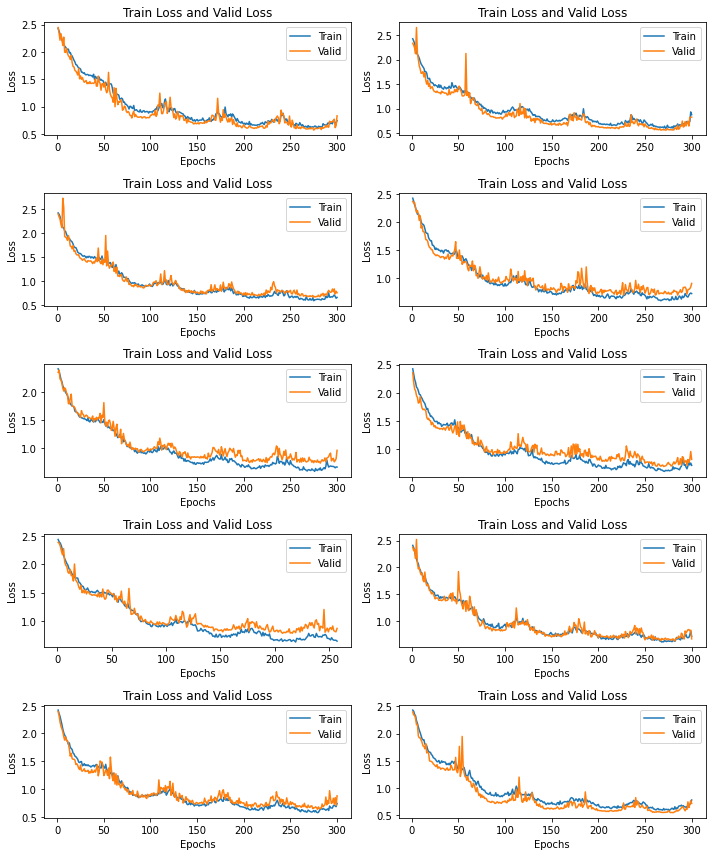

In [40]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(5, 2, figsize=(10, 12))
for i, ax in enumerate(axs.flatten()):
    show_loss_plot(net_epoch_train_loss[i], net_epoch_valid_loss[i], ax)
fig.tight_layout()

## test 예측

`-` softmax function을 취하면 11개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [41]:
def predict(model: nn.Module, dataloader, weight_save_path, is_prob=False) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 데이터를 예측하여 반환"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD) 
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값 

In [74]:
test_dataset = CustomDataset(test_images, label_list=None, train_mode=False, transforms=get_transform(train_mode=False))  
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
net = CNN().to(device)

In [66]:
pred = predict(net, test_dataloader, SAVE_PATH)

In [67]:
label_pred = label_encoding_inverse_transform(pd.Series(pred))

In [68]:
submission['label'] = label_pred
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8
